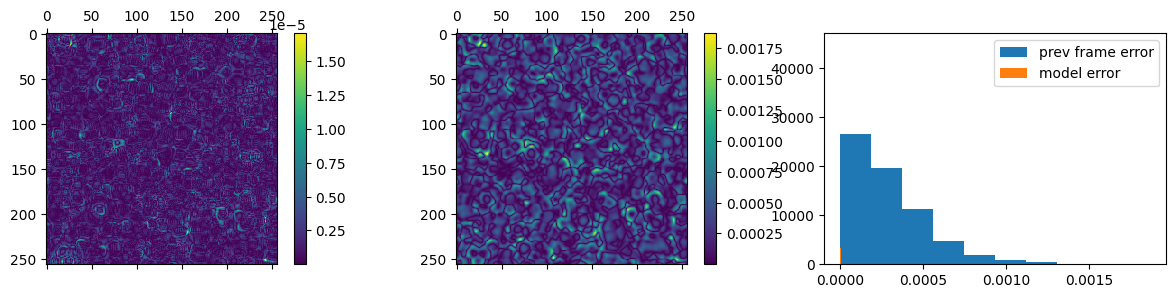

In [625]:
import torch 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

device = "cuda"
torch.set_grad_enabled(False)
torch.set_default_device(device)

def pad(X, axis, extent, mode="circular", val_left=None, val_right=None):
    X = X.transpose(axis, -1)

    if mode == "circular":
        assert extent <= X.shape[-1]
        left, right = X[...,-extent:], X[...,:extent]
    elif mode == "dirichlet": 
        shape = list(X.shape[:-1]) + [extent]
        left, right = torch.ones(shape)*val_left, torch.ones(shape)*val_right
    else:
        raise Exception

    X = torch.cat((left, X, right), dim=-1)
    X = X.transpose(axis, -1)
    return X

def conv1d(X, axis, kernel, channels=True):
    # assumes d takes the form 
    # batch x channels x a1 x a2 ... x an OR
    # batch x a1 x a2 ... x an
    if not channels: 
        X = X.unsqueeze(1)
        axis += 1
    
    # moves axis and channel to the right
    X = X.transpose(axis, -1)
    X = X.transpose(1, -2)

    # conflates the first few axes
    shape = X.shape
    # X = X.view(-1, *shape[-2:])
    X = X.reshape(-1, *shape[-2:])

    # applies kernel and inverts the permutation
    X = kernel(X)
    X = X.view(*shape[:-2], *X.shape[-2:])

    X = X.transpose(1, -2)
    X = X.transpose(axis, -1)
    if not channels: X = X.squeeze(1)
    return X

def unpad(X, axis, extent): # removes padding from axis
    X = X.transpose(axis, -1)
    X = X[...,extent:-extent]
    X = X.transpose(axis, -1)
    return X


class PointwiseLinear(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.layer = torch.nn.Linear(in_dim, out_dim, bias=False).double()

    def forward(self, X):
        X = X.transpose(1,-1) # shifts the channel axis to the last index
        Y = self.layer(X)
        Y = Y.transpose(1,-1)
        return Y

    def train(self, X, Y):
        X = X.transpose(1,-1) # shifts the channel axis to the last index
        X = X.reshape(-1,X.shape[-1]) # conflates the first few axes, except for input dimension
        Y = Y.transpose(1,-1).reshape(-1, 1) # shifts the channel axis to the last index
        # A = torch.linalg.lstsq(X, Y, driver="gelsd", rcond=1e-6).solution.transpose(0,1)
        A = torch.linalg.lstsq(X, Y).solution.transpose(0,1)
        self.layer.weight.data = A

class LaplaceConcatenator(torch.nn.Module):
    def __init__(self, in_dim, nr_conv_channels=1): #, bc=[{"mode":"circular"}, {"mode":"circular"}]):
        super().__init__()

        # hard-coded finite-difference kernels
        # dx = torch.tensor([1/280, -4/105, 1/5, -4/5, 0, 4/5, -1/5, 4/105, -1/280 ]).double()
        dxx = torch.tensor([-1/560, 8/315, -1/5, 8/5, -205/72, 8/5, -1/5, 8/315, -1/560 ]).double()
        # dxxxx = torch.tensor([7/240, -2/5, 169/60, -122/15, 91/8, -122/15, 169/60, -2/5, 7/240 ]).double()
        # dxx = torch.tensor([-1/12, 4/3, -5/2, 4/3, -1/12]).double()
        # dxx = torch.tensor([1, -2, 1]).double()

        self.in_dim = in_dim
        # self.out_dim = out_dim 
        self.ks = dxx.shape[0]
        self.extent = (self.ks-1)//2
        # self.bc = bc
        self.nr_conv_channels = nr_conv_channels
        # self.conv_dx = torch.nn.Conv1d(1, 1, self.ks, bias=False).double()
        # self.conv_dx.weight.data = dx.view(1,1,self.ks)
        # self.conv_dxx = torch.nn.Conv1d(1, 1, self.ks, bias=False).double()
        self.conv_dxx = torch.nn.Conv1d(1, self.nr_conv_channels, self.ks, bias=False).double()
        # w = self.conv_dxx.weight.data
        # self.conv_dxx.weight.data = 1/2*w + 1/2*w.flip(2)
        self.conv_dxx.weight.data = dxx.view(1,1,self.ks)

    # def grad(self, X):
    #     # X has shape: batch x dim1 x dim2 x ...
    #     nr_dims = len(X.shape[1:])
    #     # gradX has shape: batch x [nr dims] x dim1 x dim2 x ...
    #     gradX = torch.zeros_like(X).unsqueeze(1).repeat(1, nr_dims, *[1 for _ in range(nr_dims)])
    #     # computes convolutions
    #     for i in range(nr_dims): 
    #         tmp = pad(X, axis=i+1, extent=self.extent, **self.bc[i])
    #         tmp = conv1d(tmp, axis=i+1, kernel=self.conv_dx, channels=False)
    #         gradX[:,i,...] = tmp
    #     return gradX
    
    def lap(self, X):
        # X has shape: batch x dim1 x dim2 x ...
        # print(X.shape)
        bs = X.shape[0]
        dims = torch.tensor(X.shape[1:])
        nr_dims = len(dims)

        X = X.unsqueeze(1)
        lapX = torch.zeros([bs, self.nr_conv_channels, *(dims-2*self.extent)])
        
        for i in range(nr_dims): 
            tmp = conv1d(X, axis=i+2, kernel=self.conv_dxx) # computes convolution along axis
            for j in range(nr_dims): # removes padding from other dimensions
                if i == j: continue
                tmp = unpad(tmp, axis=j+2, extent=self.extent)
            lapX += tmp
        return lapX

    def forward(self, X):
        # X has shape: batch x channels x dim1 x dim2 x ...
        # computes a vector of size batch x channels x dim1 x dim2 x ...

        dims_shape = X.shape[2:]
        new_dims_shape = torch.tensor(dims_shape) - 2*self.extent
        bs = X.shape[0]
        nr_channels = X.shape[1]

        X_squeezed = X.reshape(-1, *dims_shape)
        L = self.lap(X_squeezed)
        L = L.view(bs, nr_channels * self.nr_conv_channels, *new_dims_shape)

        # removes padding from input
        for axis in range(len(dims_shape)): 
            X = unpad(X, axis+2, self.extent)

        X = torch.cat((X, L), dim=1)
        return X
    
class Model(torch.nn.Module):
    def __init__(self, conv_channels1, hidden, conv_channels2, bc):
        super().__init__()
        self.conv_channels1 = conv_channels1
        self.conv_channels2 = conv_channels2
        self.hidden = hidden
        self.bc = bc

        self.lp1 = LaplaceConcatenator(in_dim=1, nr_conv_channels=self.conv_channels1)
        self.lin1 = PointwiseLinear(in_dim=1+self.conv_channels1, out_dim=self.hidden)
        self.nl = torch.nn.Softplus()
        self.lp2 = LaplaceConcatenator(in_dim=hidden, nr_conv_channels=self.conv_channels2)
        self.lin2 = PointwiseLinear(hidden*(1+self.conv_channels2), hidden)
        # self.nl = torch.nn.Softplus()
        # self.lp3 = LaplaceConcatenator(in_dim=hidden, nr_conv_channels=self.conv_channels2)
        # self.lin3 = PointwiseLinear(hidden*(1+self.conv_channels2), 1)

        self.extent = self.lp1.extent + self.lp2.extent # + self.lp3.extent

    def pad(self, X):
        for i in range(len(X.shape)-1): 
            X = pad(X, axis=i+1, extent=self.extent, **self.bc[i])
        return X

    def phi(self, X):
        # X has shape: batch x dim1 x dim2 x ...
        X = self.pad(X)
        X = X.unsqueeze(1)
        X = self.lp1(X)
        X = self.lin1(X)
        X = self.nl(X)
        X = self.lp2(X)
        # X = self.lin2(X)
        # X = self.nl(X)
        # X = self.lp3(X)
        return X

    def forward(self, X):
        return self.lin2(self.phi(X)).squeeze(1)

    def train(self, X, Y):
        self.lin2.train(self.phi(X), Y)


D = torch.tensor(np.load("ks2d_short.npy"))
maxval, minval = D.max(), D.min()
normalize = lambda x: (x-minval)/(maxval-minval)
denormalize = lambda x: x*(maxval-minval)+minval
D = normalize(D)
         
# boundary conditions used in training data
BC_0 = { "mode": "circular", "val_left": None, "val_right": None }
BC_1 = { "mode": "circular", "val_left": None, "val_right": None }

X, Y = D[0,None,...], D[1,None,...]
X_noisy = X + torch.distributions.Normal(0, 1e-5).sample(X.shape) 
model = Model(1, 10, 1, [BC_0, BC_1])
# model.train(X,Y)
model.train(X_noisy, Y)

k = 1
Z = X
for _ in range(k): Z = model(Z)
err = (Z - D[k,None,:,:])[0,:,:].abs().cpu()
prev_frame_error = (X - D[k,None,:,:])[0,:,:].abs().cpu()

fig, ax = plt.subplots(1,3,figsize=(15,3))
plt.colorbar(ax[0].matshow(err))
plt.colorbar(ax[1].matshow(prev_frame_error))
ax[2].hist(prev_frame_error.flatten(),label="prev frame error")
ax[2].hist(err.flatten(), label="model error")
ax[2].legend()
plt.show()

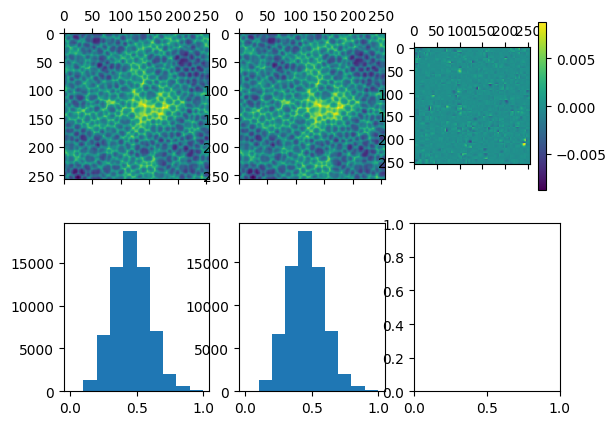

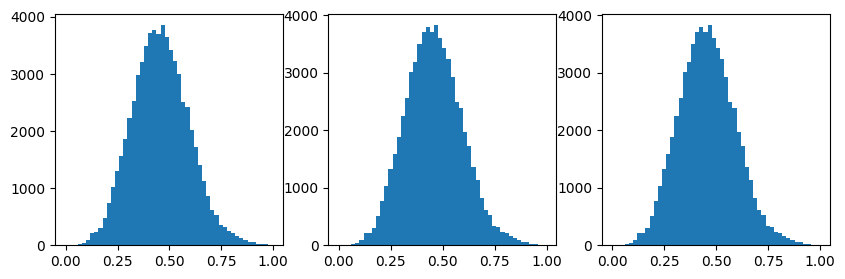

torch.Size([256, 256])


tensor(0.0355, device='cuda:0', dtype=torch.float64)

In [626]:
fig, ax = plt.subplots(2,3)
Z = X
k = 8
for _ in range(k): Z = model(Z)
ax[0][0].matshow( Z[0,...].cpu().numpy(), vmin=0, vmax=1 )
ax[0][1].matshow( D[k,...].cpu().numpy(), vmin=0, vmax=1 )
plt.colorbar( ax[0][2].matshow( ( Z[0,...] - D[k,...] ).cpu().numpy() ) )

ax[1][0].hist(Z[0,...].flatten().cpu().numpy())
ax[1][1].hist(D[k,...].flatten().cpu().numpy())
plt.show()

fig, ax = plt.subplots(1,3,figsize=(10,3))
ax[0].hist( model(Z).cpu().flatten().numpy(), bins=50 )
ax[1].hist( model(D[k,None,...])[0,...].cpu().flatten().numpy(), bins=50)
ax[2].hist( D[k+1,...].cpu().flatten().numpy(), bins=50 )
plt.show()

max_error = ( model(Z)[0,...]-D[k+1,...] ).abs()
print(max_error.shape)
max_error.max()

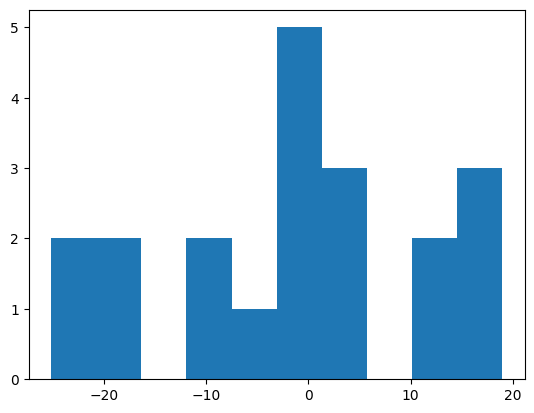

In [627]:
plt.hist(model.lin2.layer.weight.data.flatten().cpu())
plt.show()

0.0
1.7069668902025548e-05
3.227614497014475e-05
4.8297577976419426e-05
6.631437176829458e-05
0.0001672201394428141
0.0005906217760808796
0.0022711817161800707
0.008836672648384836
0.03553420748726127


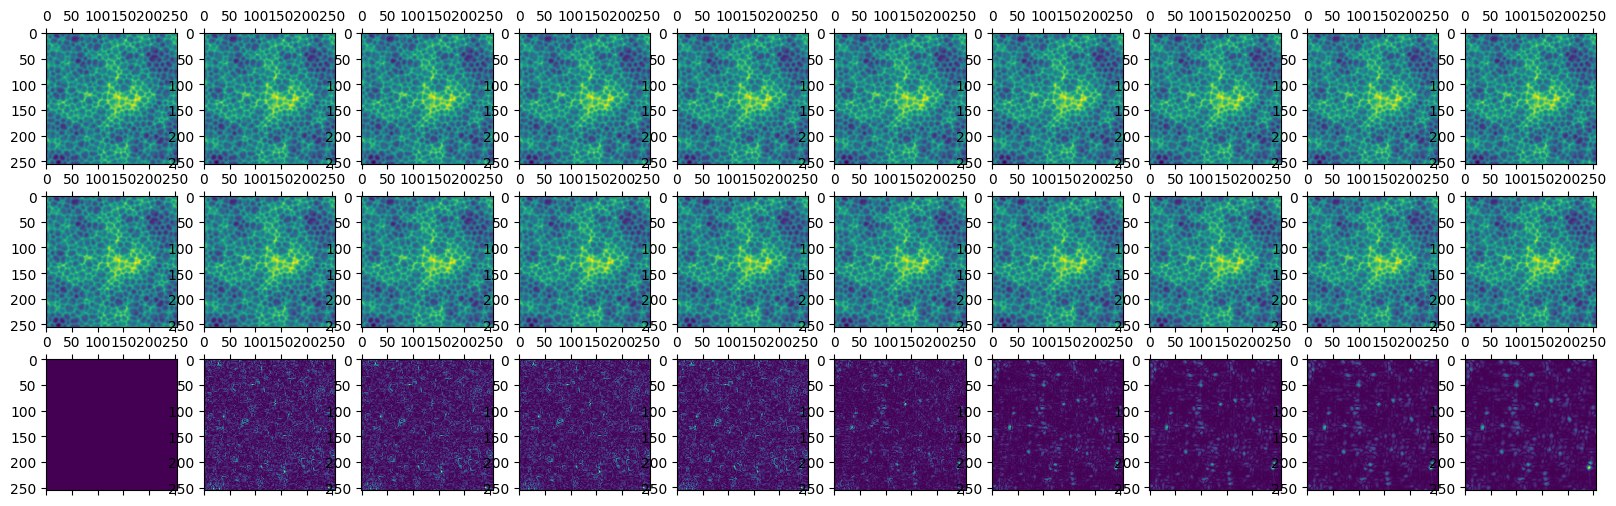

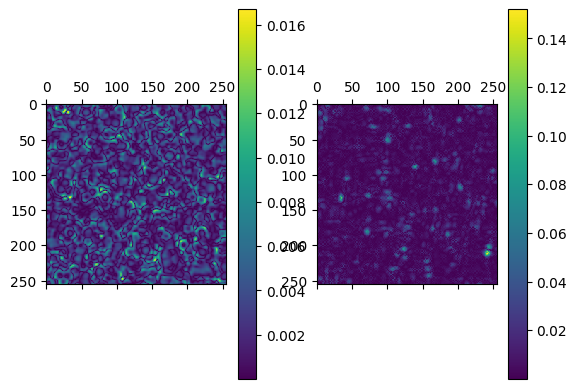

In [628]:
Xs = [ X ]
n_plots = 10
fig, ax = plt.subplots(3,n_plots,figsize=(20,6))
for i in range(n_plots): 
    ax[0][i].matshow(Xs[i][0,:,:].cpu(),vmax=1,vmin=0)
    ax[1][i].matshow(D[i,:,:].cpu(),vmax=1,vmin=0)
    err = (D[i,:,:] - Xs[i][0,:,:]).abs().cpu()
    ax[2][i].matshow(err)
    print(err.max().item())
    Xs.append(model(Xs[i]))
plt.show()

fig, ax = plt.subplots(1,2)
plt.colorbar(ax[0].matshow( (D[0,...]-D[-1,...]).abs().cpu() ))
plt.colorbar(ax[1].matshow( (Xs[0][0,...]-Xs[-1][0,...]).abs().cpu() ))

In [629]:
# enjoy a nice animation
import itertools
import time
%matplotlib qt
torch.set_grad_enabled(False)

# Dirichlet boundary conditions
# BC_0 = { "mode": "dirichlet", "val_left": 0, "val_right": 0 } # vertical axis
# BC_1 = { "mode": "dirichlet", "val_left": 0, "val_right": 0 } # horizontal axis
# model.bc = [BC_0, BC_1]
# 
# # fit initial condition to the boundary conditions, i.e., smoothly transition
# # boundary values to 0
# T = X
# z = torch.sin(torch.linspace(0,torch.pi,X.shape[2])).expand_as(T)
# z = z * torch.sin(torch.linspace(0,torch.pi,X.shape[2])).expand_as(T).transpose(2,3)
# T = T * z
T = X


im = plt.matshow(T[0,...].cpu().numpy(), vmin=0, vmax=1)
model_fast= model # .to(torch.float32).to(device)
T_fast = T # .to(torch.float32).to(device)
# energy = T_fast.mean()
for j in itertools.count():
    T_fast = model_fast(T_fast)
    # time.sleep(.1)
    # T_fast = energy + T_fast - T_fast.mean()
    if j % 1 == 0:
        im.set_data(T_fast[0,...].cpu().numpy())
        plt.pause(0.000001)
        plt.draw()
        # input()
        # print("x")

KeyboardInterrupt: 